In [ ]:
# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pickle
import numpy as np
np.set_printoptions(suppress=True)

import bayesflow as beef
import tensorflow as tf

import sys
sys.path.append("../")
from experiments import SmoothingExperiment, FilteringExperiment
sys.path.append("../../../assets/")
from models import MixtureRandomWalkDDM

In [ ]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

In [28]:
SIMULATE_VALIATION_DATA = False
FIT_MODEL = False

NUM_OBS = 800
NUM_SAMPLES = 1000
NUM_VALIDATION_SIMULATIONS = 500

MICRO_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
MICRO_PARAM_NAMES  = [r'v', r'a', r'\tau']
MACRO_PARAM_LABELS = ['Transition std. deviation', 'Switch Probability']
MACRO_PARAM_NAMES  = [r'\sigma', r'q']
COMPARISON_COLOR = '#133a76'

HYPER_PARAM_NAMES = [r'\sigma_{v}', r'\sigma_{a}', r'\sigma_{\tau}', r'q_{v}', r'q_{a}']

FONT_SIZE_1 = 22
FONT_SIZE_2 = 20
FONT_SIZE_3 = 18

FIG_SIZE = (18, 8)

In [ ]:
model = MixtureRandomWalkDDM()
smoothing_experiment = SmoothingExperiment(model, "checkpoints/smoothing_summary_network")
filtering_experiment = FilteringExperiment(model, "checkpoints/filtering_summary_network")

In [ ]:
%%time
if SIMULATE_VALIATION_DATA:
    validation_data = model.generate(NUM_VALIDATION_SIMULATIONS)
    with open('../data/validation_data.pkl', 'wb') as f:
        pickle.dump(validation_data, f)
else:
    with open('../data/validation_data.pkl', 'rb') as f:
        validation_data = pickle.load(f)

In [10]:
true_hyper_params = validation_data['hyper_prior_draws']
true_hyper_params.shape

(500, 5)

In [ ]:
%%time
if FIT_MODEL:
    smoothing_post_hyper_params = np.zeros((NUM_VALIDATION_SIMULATIONS, NUM_SAMPLES, 5))
    smoothing_post_local_params = np.zeros((NUM_VALIDATION_SIMULATIONS, NUM_OBS, NUM_SAMPLES, 3))
    filtering_post_hyper_params = np.zeros((NUM_VALIDATION_SIMULATIONS, NUM_SAMPLES, 5))
    filtering_post_local_params = np.zeros((NUM_VALIDATION_SIMULATIONS, NUM_OBS, NUM_SAMPLES, 3))
    configured_val_data = model.configure(validation_data)['summary_conditions']
    for i in range(NUM_VALIDATION_SIMULATIONS):
        # fit smoothing network
        smoothing_post_samples = smoothing_experiment.amortizer.sample(
            {'summary_conditions': configured_val_data[i:i+1]},
            NUM_SAMPLES
            )
        smoothing_post_hyper_params[i] = smoothing_post_samples['global_samples']
        smoothing_post_local_params[i] = smoothing_post_samples['local_samples']
        # fit filtering network
        filtering_post_samples = filtering_experiment.amortizer.sample(
            {'summary_conditions': configured_val_data[i:i+1]},
            NUM_SAMPLES
            )
        filtering_post_hyper_params[i] = filtering_post_samples['global_samples']
        filtering_post_local_params[i] = filtering_post_samples['local_samples']
        
    with open('../data/smoothing_post_hyper_params.pkl', 'wb') as f:
        pickle.dump(smoothing_post_hyper_params, f)
    with open('../data/smoothing_post_local_params.pkl', 'wb') as f:
        pickle.dump(smoothing_post_local_params, f)
    with open('../data/filtering_post_hyper_params.pkl', 'wb') as f:
        pickle.dump(filtering_post_hyper_params, f)
    with open('../data/filtering_post_local_params.pkl', 'wb') as f:
        pickle.dump(filtering_post_local_params, f)
else:
    with open('../data/smoothing_post_hyper_params.pkl', 'rb') as f:
        smoothing_post_hyper_params = pickle.load(f)
    with open('../data/smoothing_post_local_params.pkl', 'rb') as f:
        smoothing_post_local_params = pickle.load(f)
    with open('../data/filtering_post_hyper_params.pkl', 'rb') as f:
        filtering_post_hyper_params = pickle.load(f)
    with open('../data/filtering_post_local_params.pkl', 'rb') as f:
        filtering_post_local_params = pickle.load(f)

## Hyperparameter Recovery

### Smoothing

In [12]:
smoothing_post_hyper_params_not_z = smoothing_post_hyper_params * model.hyper_prior_std + model.hyper_prior_mean

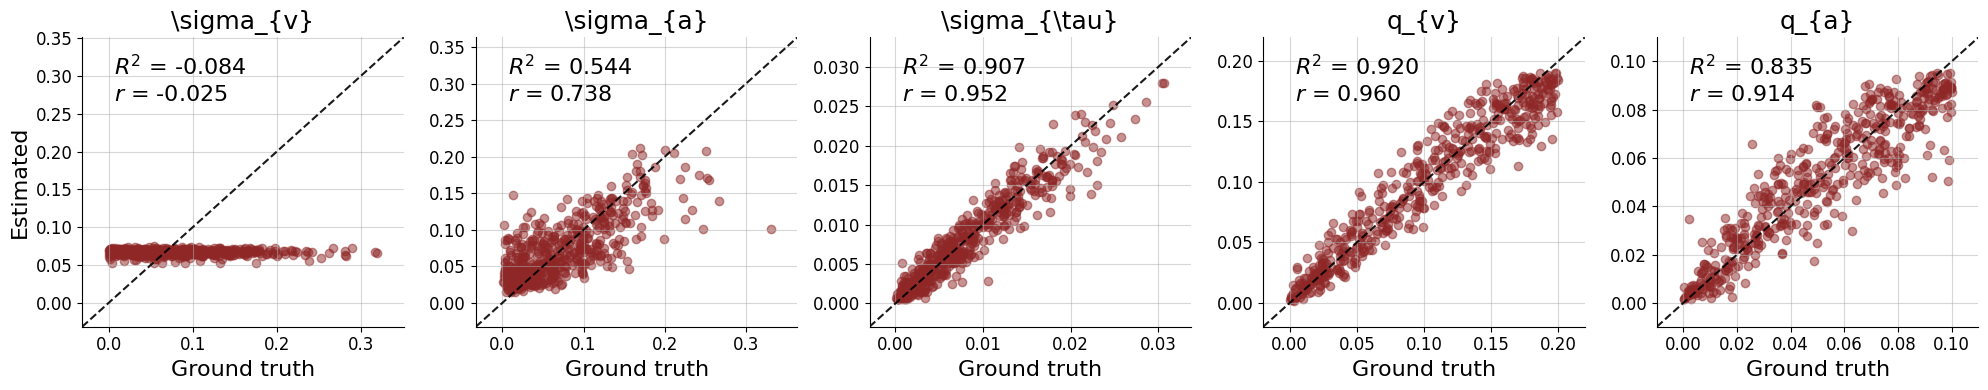

In [31]:
p = beef.diagnostics.plot_recovery(
    smoothing_post_hyper_params_not_z,
    true_hyper_params,
#     n_row=2,
    uncertainty_agg=None,
    param_names=HYPER_PARAM_NAMES
)

### Filtering

In [14]:
filtering_post_hyper_params_not_z = filtering_post_hyper_params * model.hyper_prior_std + model.hyper_prior_mean

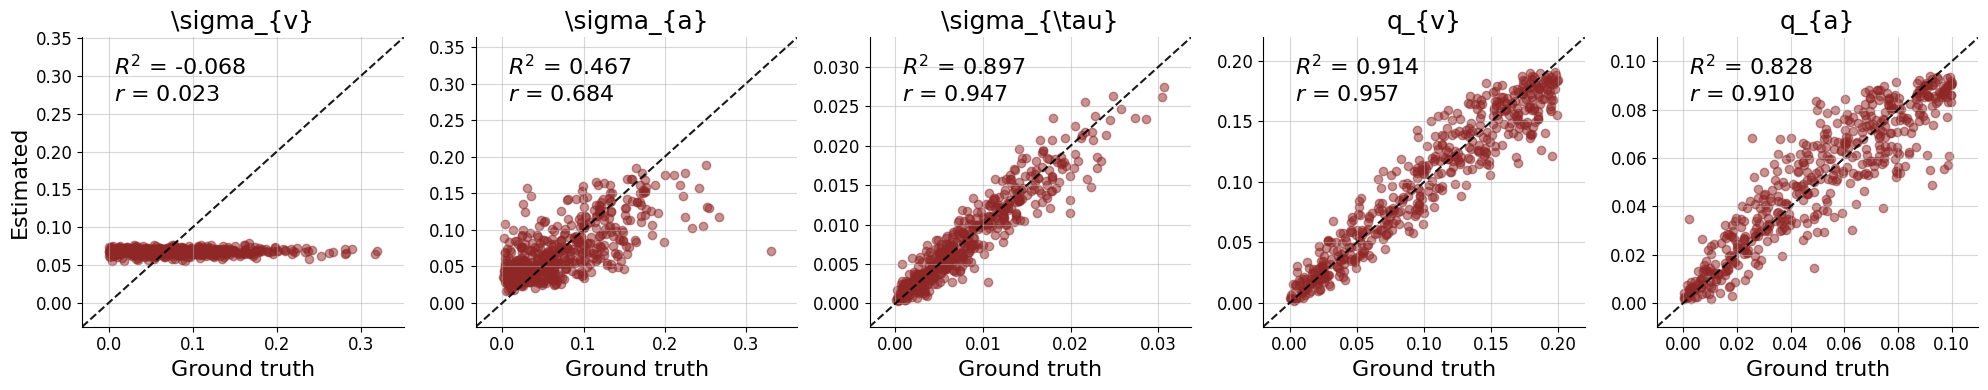

In [32]:
p = beef.diagnostics.plot_recovery(
    filtering_post_hyper_params_not_z,
    true_hyper_params,
#     n_row=2,
    uncertainty_agg=None,
    param_names=HYPER_PARAM_NAMES
)